In [1]:
import numpy as np
import pandas as pd

In [2]:
train = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
train.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [3]:
from glob import glob

train_jpg = glob('../input/petfinder-pawpularity-score/train/*.jpg')
test_jpg = glob('../input/petfinder-pawpularity-score/test/*.jpg')

In [4]:
test = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')
test.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [5]:
len(train_jpg)

9912

In [6]:
len(test_jpg)

8

In [7]:
train.shape

(9912, 14)

In [8]:
test.shape

(8, 13)

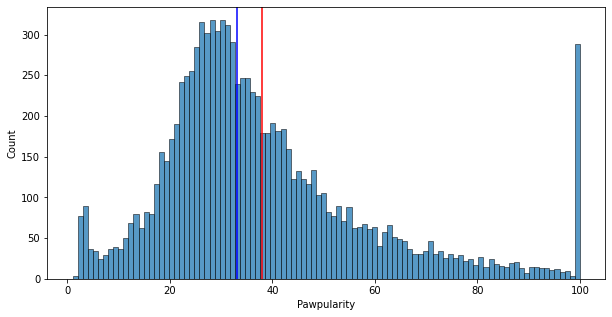

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 5))
sns.histplot(train['Pawpularity'], bins = 100)
plt.axvline(train['Pawpularity'].mean(), c = 'red', label = 'Mean')
plt.axvline(train['Pawpularity'].median(), c = 'blue', label = 'Median')
plt.show()

shape (960, 720, 3)


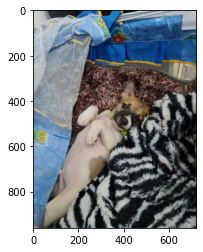

shape (720, 405, 3)


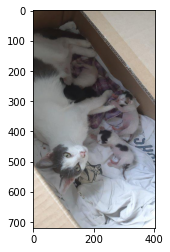

shape (514, 315, 3)


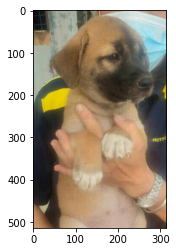

shape (1280, 1280, 3)


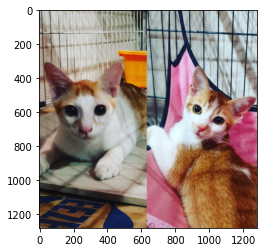

shape (960, 720, 3)


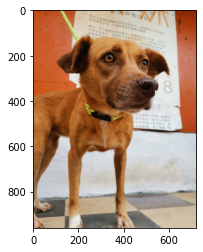

In [10]:
for i in range(5):
    img_path = train_jpg[i]
    img_arr = plt.imread(img_path)
    print('shape', img_arr.shape)
    plt.imshow(img_arr)
    plt.show()

shape (128, 128, 3)


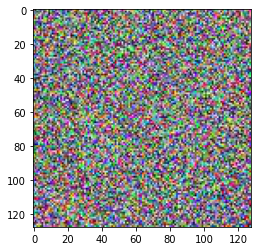

shape (128, 128, 3)


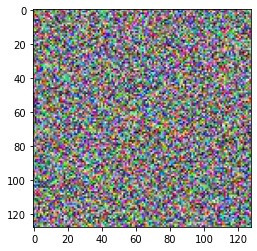

shape (128, 128, 3)


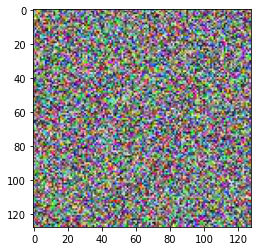

shape (128, 128, 3)


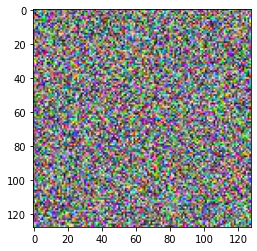

shape (128, 128, 3)


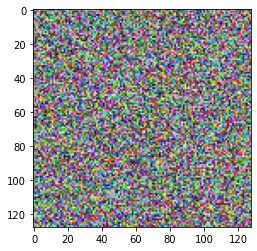

shape (128, 128, 3)


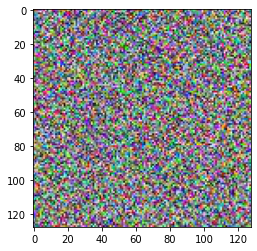

shape (128, 128, 3)


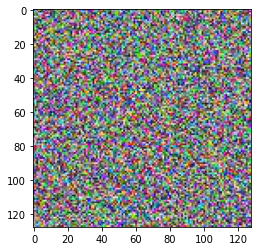

shape (128, 128, 3)


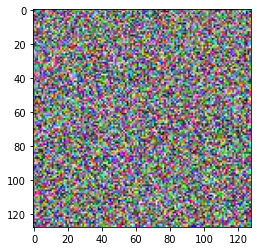

In [11]:
for i in range(8):
    img_path = test_jpg[i]
    img_arr = plt.imread(img_path)
    print('shape', img_arr.shape)
    plt.imshow(img_arr)
    plt.show()

In [12]:
import os
import cv2

# os.chdir('../input/petfinder-pawpularity-score/train')
# train_img = []
# for file in os.listdir():
#     img = cv2.imread(file)
#     img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_AREA)
#     train_img.append(img/255)

In [13]:
train["file_path"] = train["Id"].apply(lambda x: "../input/petfinder-pawpularity-score/train/" + x + ".jpg")
test["file_path"] = test["Id"].apply(lambda x: "../input/petfinder-pawpularity-score/test/" + x + ".jpg")

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(train, test_size = 0.2, random_state = 2020)

In [15]:
import tensorflow as tf

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0, shear_range = 0.2, horizontal_flip = True, 
                                                               zoom_range = 0.2, vertical_flip = True, fill_mode='nearest')

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)

train_gen = train_datagen.flow_from_dataframe(dataframe = X_train, x_col = 'file_path', y_col = 'Pawpularity', target_size = (224, 224),
                                             batch_size = 32, class_mode ='raw', shuffle = False, validate_filenames=False)

val_gen = val_datagen.flow_from_dataframe(dataframe =  X_val, x_col = 'file_path', y_col = 'Pawpularity', target_size = (224, 224),
                                             batch_size = 32, class_mode ='raw', shuffle = False, validate_filenames=False)

test_gen = test_datagen.flow_from_dataframe(dataframe =  test, x_col = 'file_path', y_col = None, target_size = (224, 224), class_mode = None, batch_size = 32, shuffle = False, validate_filenames=False)

Found 7929 non-validated image filenames.
Found 1983 non-validated image filenames.
Found 8 non-validated image filenames.


In [16]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D, Flatten

efnet = tf.keras.models.load_model('../input/effnet/EfficientNetB0.h5')
efnet.trainable = False

model = Sequential([
    Input(shape = (224, 224, 3)),
    efnet,
    Dropout(0.2),
    Dense(units = 100, activation="relu"),
    Dense(units = 1, activation="relu")
    
])

2021-12-30 08:17:11.177967: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-30 08:17:11.262147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-30 08:17:11.262816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-30 08:17:11.263832: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [17]:
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 1e-4, decay_steps = 100, decay_rate = 0.99)
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)

In [18]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr_scheduler), loss = 'mse', metrics = [tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(train_gen, epochs = 30, verbose = 1, validation_data = val_gen, callbacks = [early_stopping])

2021-12-30 08:17:17.286678: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2021-12-30 08:17:23.434476: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


248/248 [==============================] - 225s 864ms/step - loss: 1646.7130 - root_mean_squared_error: 40.5797 - val_loss: 1373.1497 - val_root_mean_squared_error: 37.0560
Epoch 2/30
248/248 [==============================] - 175s 707ms/step - loss: 1124.0728 - root_mean_squared_error: 33.5272 - val_loss: 885.9655 - val_root_mean_squared_error: 29.7652
Epoch 3/30
248/248 [==============================] - 175s 705ms/step - loss: 714.0903 - root_mean_squared_error: 26.7225 - val_loss: 578.6262 - val_root_mean_squared_error: 24.0547
Epoch 4/30
248/248 [==============================] - 176s 708ms/step - loss: 513.7221 - root_mean_squared_error: 22.6654 - val_loss: 458.7773 - val_root_mean_squared_error: 21.4191
Epoch 5/30
248/248 [==============================] - 176s 708ms/step - loss: 448.7461 - root_mean_squared_error: 21.1836 - val_loss: 429.6525 - val_root_mean_squared_error: 20.7281
Epoch 6/30
248/248 [==============================] - 175s 704ms/step - loss: 443.7132 - root_mean

In [19]:
 model.save("model_effnet.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


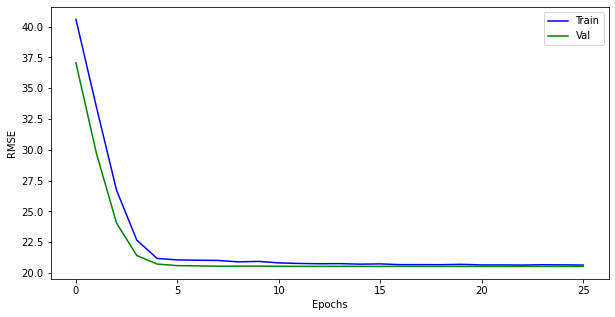

In [20]:
acc = history.history['root_mean_squared_error']
val_acc = history.history['val_root_mean_squared_error']
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize = (10, 5))
plt.plot(range(len(acc)), acc, 'b', label = 'Train')
plt.plot(range(len(acc)), val_acc, 'g', label = 'Val')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

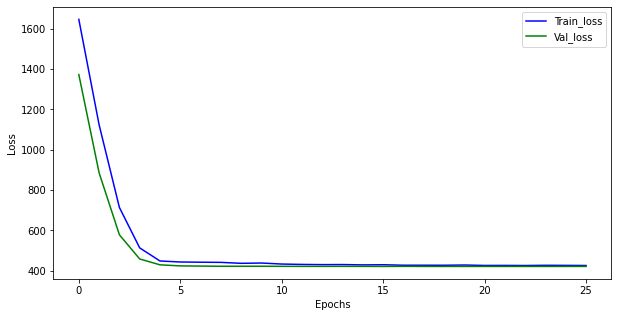

In [21]:
plt.figure(figsize = (10, 5))
plt.plot(range(len(acc)), loss, 'b', label = 'Train_loss')
plt.plot(range(len(acc)), val_loss, 'g', label = 'Val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
preds = model.predict(test_gen)

In [23]:
sub = pd.read_csv('../input/petfinder-pawpularity-score/sample_submission.csv')
sub['Pawpularity'] = preds

In [24]:
sub.to_csv('submission.csv', index=False)